# Survival *lifelines*
[https://lifelines.readthedocs.io/](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [81]:
#df_files = pd.read_csv("datasets/cancers/lung/files.txt", sep="\t", index_col=0).dropna(how="all", thresh=300, axis=1)
df_files = pd.read_csv("datasets/cancers/merged_lung/files.dat", sep=",",index_col=0).dropna(how="all", thresh=100, axis=1)
df_files = df_files[df_files["dataset"]=="tcga"]
df_files.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1102 entries, TCGA-43-7657-11A-01R-2125-07 to TCGA-64-1680-01A-02R-0946-07
Data columns (total 20 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   primary_site                                   1102 non-null   object 
 1   status                                         1102 non-null   object 
 2   dataset                                        1102 non-null   object 
 3   tissue_hd                                      1102 non-null   object 
 4   Subtype                                        1102 non-null   object 
 5   Type                                           1102 non-null   object 
 6   cases.0.demographic.days_to_birth              1046 non-null   float64
 7   cases.0.demographic.days_to_death              438 non-null    float64
 8   cases.0.demographic.gender                     1092 non-null   object 
 9   cases.

In [82]:
df_files["cases.0.diagnoses.0.last_known_disease_status"].unique()

array(['not reported', nan], dtype=object)

In [83]:
bins = np.linspace(0,100,20)
avg = df_files["cases.0.diagnoses.0.age_at_diagnosis"].mean(skipna=True)
df_files["age_at_diagnosis"]=pd.cut(df_files["cases.0.diagnoses.0.age_at_diagnosis"].fillna(avg)/365., bins=bins, labels = (bins[1:]+bins[:-1])/2).__array__()

In [84]:
df_files["gender"] = (df_files["cases.0.demographic.gender"]=="male").astype(int)

In [85]:
for letter in ["a", "b"]:
    for (old, new) in zip(["stage %s%s"%(i,letter) for i in ["i", "ii", "iii", "iv"]],["stage %s"%i for i in ["i", "ii", "iii", "iv"]]):
        df_files.replace(old, new, inplace=True)
df_files["cases.0.diagnoses.0.tumor_stage"].unique()

array(['stage i', 'stage iv', 'stage ii', 'stage iii', nan,
       'not reported'], dtype=object)

In [86]:
df_files["tumor_stage"]=df_files["cases.0.diagnoses.0.tumor_stage"]
for i,stage in enumerate(["stage i", "stage ii", "stage iii", "stage iv", "stage v"]):
    df_files["tumor_stage"].replace(stage, i+1, inplace=True)

In [87]:
#1 = Alive
df_files["vital_status"]=(df_files["cases.0.demographic.vital_status"]=="Dead").astype(int)

['not reported' nan]


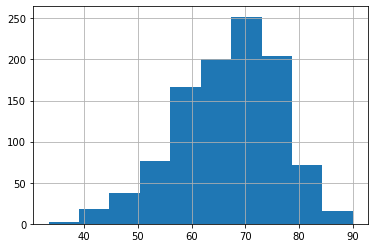

In [88]:
print(df_files["cases.0.diagnoses.0.last_known_disease_status"].unique())
(df_files["cases.0.diagnoses.0.age_at_diagnosis"]/365).hist()

In [89]:
def get_survival(case):
    if case["cases.0.demographic.vital_status"] == 1:
        return case["cases.0.demographic.days_to_death"]
    else:
        return case["cases.0.diagnoses.0.days_to_last_follow_up"]

df_files["days_survival"] = df_files.apply(get_survival,1)

In [90]:
bins = np.linspace(0,100,10)
df_files["smoke"] = pd.cut(df_files["cases.0.exposures.0.years_smoked"], bins=bins, labels = (bins[1:]+bins[:-1])/2 ).__array__()
df_files["smoke"].fillna(0, inplace=True)

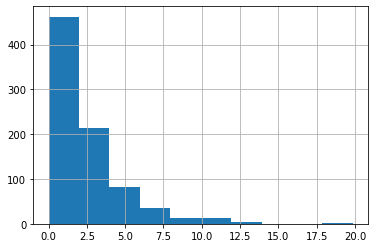

In [91]:
(df_files["days_survival"]/365).hist()

In [92]:
subset = df_files[~df_files["days_survival"].isna()].sample(80)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  app.launch_new_instance()


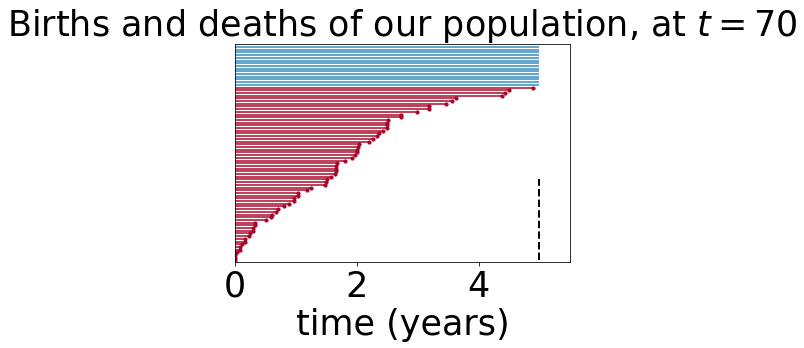

In [93]:
from lifelines.plotting import plot_lifetimes

CURRENT_TIME = 5

actual_lifetimes = subset["days_survival"].to_numpy()/365
observed_lifetimes = np.minimum(actual_lifetimes, CURRENT_TIME)
death_observed = actual_lifetimes < CURRENT_TIME

ax = plot_lifetimes(observed_lifetimes, event_observed=death_observed, figsize=(18,15))

ax.set_xlim(0, CURRENT_TIME*1.1)
ax.vlines(CURRENT_TIME, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("time (years)", fontsize=35)
ax.tick_params(labelsize=35)
ax.set_title("Births and deaths of our population, at $t=70$", fontsize=35)
plt.tight_layout()
#print("Observed lifetimes at time %d:\n" % (CURRENT_TIME), observed_lifetimes)

In [94]:
subset = df_files[~df_files["days_survival"].isna()]
data = {}
data["duration"]=subset["days_survival"]/365
data["observed"]=subset["vital_status"]
data["entry"]=subset["cases.0.demographic.days_to_birth"]/365

In [95]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [96]:
df_files["vital_status"].sum()

446

In [97]:
T = data["duration"]
E = data["observed"]
entry = data["entry"]

(0.0, 15.0)

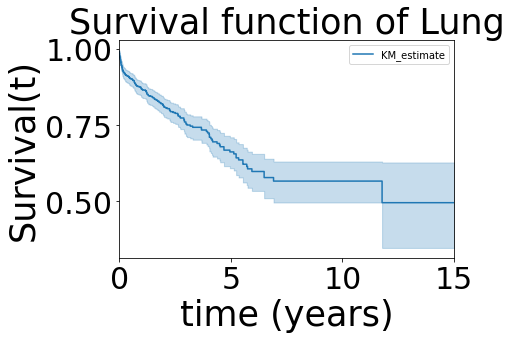

In [98]:
kmf.fit(T, event_observed=E)
ax = kmf.plot()

ax.set_title('Survival function of Lung', fontsize=35)
ax.set_xlabel("time (years)", fontsize=35)
ax.set_ylabel("Survival(t)", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_xlim(0,15)

In [99]:
from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)
print(kmf.median_survival_time_, "+-", median_ci)

11.778082191780822 +-      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                6.915068                     inf


Text(0.5, 1.0, 'Survival of different cancer types')

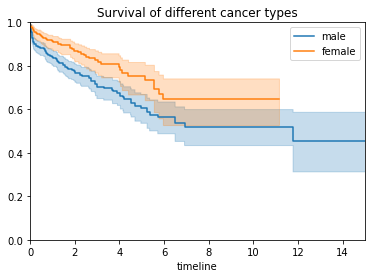

In [100]:
ax = plt.subplot(111)

mask = (subset["cases.0.demographic.gender"]=="male")

kmf.fit(T[mask], event_observed=E[mask], label="male")
kmf.plot(ax=ax)

kmf.fit(T[~mask], event_observed=E[~mask], label="female")
kmf.plot(ax=ax)

plt.ylim(0, 1)
plt.xlim(0,15)
plt.title("Survival of different cancer types")

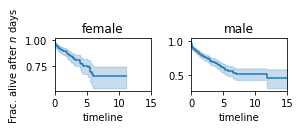

In [101]:
key = 'cases.0.demographic.gender'
labels = subset[key].unique()

for i, label in enumerate(np.sort(labels)):
    ax = plt.subplot(3, 3, i + 1)

    ix = subset[key] == label
    kmf.fit(T[ix], E[ix], label=label)
    kmf.plot(ax=ax, legend=False)

    plt.title(label)
    plt.xlim(0, 15)

    if i==0:
        plt.ylabel('Frac. alive after $n$ days')

plt.tight_layout()

In [102]:
import importlib, survival
importlib.reload(survival)
from survival import fit_cox, add_group_to_subset

In [103]:
df_clusters = pd.read_csv("datasets/cancers/lung/topsbm/topsbm_level_1_topic-dist.csv",index_col=1).drop("i_doc",1)
df_clusters = pd.read_csv("datasets/cancers/lung/lda/lda_level_2_topic-dist.csv",index_col=1).drop("i_doc",1)

df_clusters = pd.read_csv("datasets/cancers/merged_lung/topsbm/topsbm_level_1_topic-dist.csv",index_col=1).drop("i_doc",1)
df_clusters = df_clusters[df_clusters.index.isin(filter(lambda doc: "GTEX" not in doc,df_clusters.index))]

In [104]:
df_files

,primary_site,status,dataset,tissue_hd,Subtype,Type,cases.0.demographic.days_to_birth,cases.0.demographic.days_to_death,cases.0.demographic.gender,cases.0.demographic.vital_status,...,cases.0.project.project_id,cases.0.submitter_id,file_name,id,age_at_diagnosis,gender,tumor_stage,vital_status,days_survival,smoke
TCGA-43-7657-11A-01R-2125-07,Lung,healthy,tcga,Lung_healthy,healthy,healthy,-25042.0,NaN,female,Alive,...,TCGA-LUSC,TCGA-43-7657,cde3831b-6eaf-4404-8357-f700f77f94e3.FPKM.txt.gz,52b1c3c4-531a-4709-ac16-e8d36a0799e8,71.052632,0,1,0,236.0,50.000000
TCGA-58-8386-11A-01R-2296-07,Lung,healthy,tcga,Lung_healthy,healthy,healthy,-27455.0,1.0,male,Dead,...,TCGA-LUSC,TCGA-58-8386,dde579e0-d792-456b-a66b-f7ec72969680.FPKM.txt.gz,145d672f-fd8d-412d-9791-aac9efdad8c5,76.315789,1,4,1,NaN,0.000000
TCGA-22-5478-11A-11R-1635-07,Lung,healthy,tcga,Lung_healthy,LUSC.secretory,LUSC,-28978.0,24.0,male,Dead,...,TCGA-LUSC,TCGA-22-5478,8ff70f54-8735-40b1-a556-b96e8889cc0f.FPKM.txt.gz,40cf4763-33ea-4f14-aa32-4a97e48bd237,81.578947,1,1,1,24.0,0.000000
TCGA-22-5472-11A-11R-1635-07,Lung,healthy,tcga,Lung_healthy,LUSC.basal,LUSC,-24482.0,1975.0,male,Dead,...,TCGA-LUSC,TCGA-22-5472,cd961e28-af13-4780-a068-35ff5548a3d2.FPKM.txt.gz,bc978434-ce93-4bc4-aaf1-acc7dfea55a5,65.789474,1,1,1,NaN,38.888889
TCGA-43-5670-11A-01R-2125-07,Lung,healthy,tcga,Lung_healthy,healthy,healthy,-25652.0,NaN,male,Alive,...,TCGA-LUSC,TCGA-43-5670,edafd326-8c3c-4ae5-8617-e1592db868eb.FPKM.txt.gz,f954273d-bd3d-47a6-954d-f97d56075456,71.052632,1,2,0,849.0,5.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-86-8056-01A-11R-2241-07,Lung,tumor,tcga,Lung_tumor,tumor,tumor,-23369.0,NaN,female,Alive,...,TCGA-LUAD,TCGA-86-8056,3926dba3-b7b5-45c8-aa60-b8fe6dd8f114.FPKM.txt.gz,cc94451b-a78e-4d9b-a77b-49bef11370ac,65.789474,0,3,0,139.0,16.666667
TCGA-64-5815-01A-01R-1628-07,Lung,tumor,tcga,Lung_tumor,tumor,tumor,-27280.0,NaN,male,Alive,...,TCGA-LUAD,TCGA-64-5815,69fd8112-03f0-4d28-aa51-03317daf4616.FPKM.txt.gz,23a2e430-69e1-410c-9592-83b2583f3360,76.315789,1,2,0,866.0,0.000000
TCGA-44-3398-01A-01R-1107-07,Lung,tumor,tcga,Lung_tumor,tumor,tumor,-28392.0,NaN,female,Alive,...,TCGA-LUAD,TCGA-44-3398,e3b11f64-075b-49d2-8d18-85afab1cff82.FPKM.txt.gz,d0e7ab8d-4934-43e1-838c-049281ef1857,76.315789,0,1,0,1163.0,50.000000
TCGA-55-6970-01A-11R-1949-07,Lung,tumor,tcga,Lung_tumor,tumor,tumor,-24773.0,464.0,female,Dead,...,TCGA-LUAD,TCGA-55-6970,f4eb983f-0eee-4c8a-9f72-b5382957d377.FPKM.txt.gz,6b4e7fb6-4452-4b75-91e2-46321daa339f,65.789474,0,3,1,NaN,0.000000


Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): 0.4602011026925552
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): 0.20582615436313387
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): -0.0
Too low -log2(p): 0.8700857649505576
TCGA-LUSC :  Topic 1 
 coef    0.470555
p       0.019953
Name: Topic_1, dtype: float64 

Too low -log2(p): -0.0
TCGA-LUSC :  Topic 3 
 coef    0.371070
p       0.056531
Name: Topic_3, dtype: float64 

TCGA-LUSC :  Topic 4 
 coef   -0.444596
p       0.024362
Name: Topic_4, dtype: float64 

TCGA-LUSC :  Topic 5 
 coef   -0.670000
p       0.007608
Name: Topic_5, dtype: float64 

Too low -log2(p): 0.607641912346192
Too low -log2(p): -0.0
TCGA-LUSC :  Topic 8 
 coef    0.744902
p       0.002226
Name: Topic_8, dtype: float64 

TCGA-LUSC :  Topic 9 
 coef   -0.735938
p       0.002945
Name: Topic_9, dtype: float6

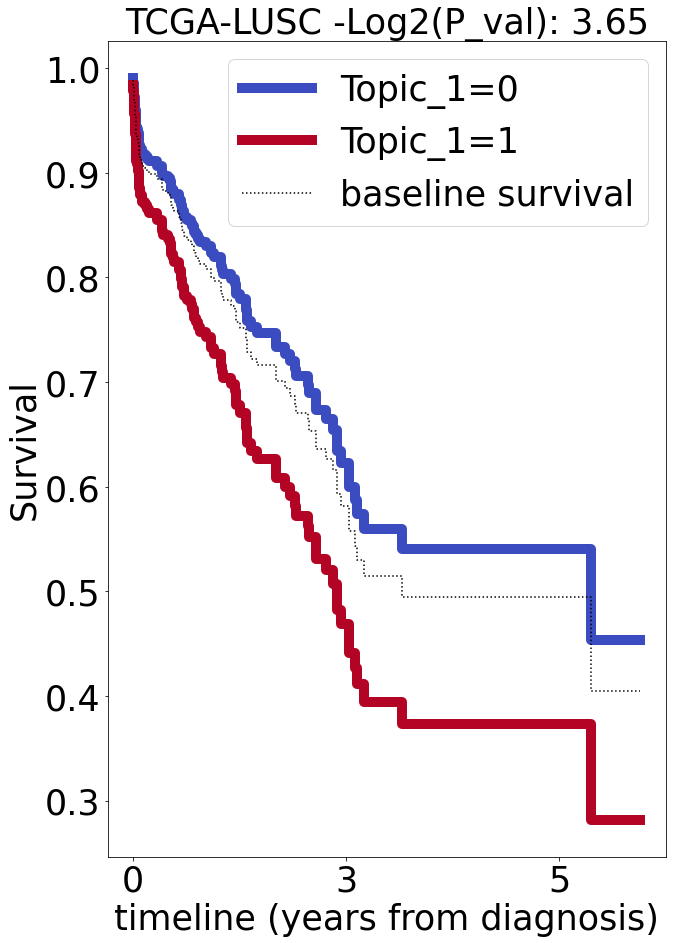

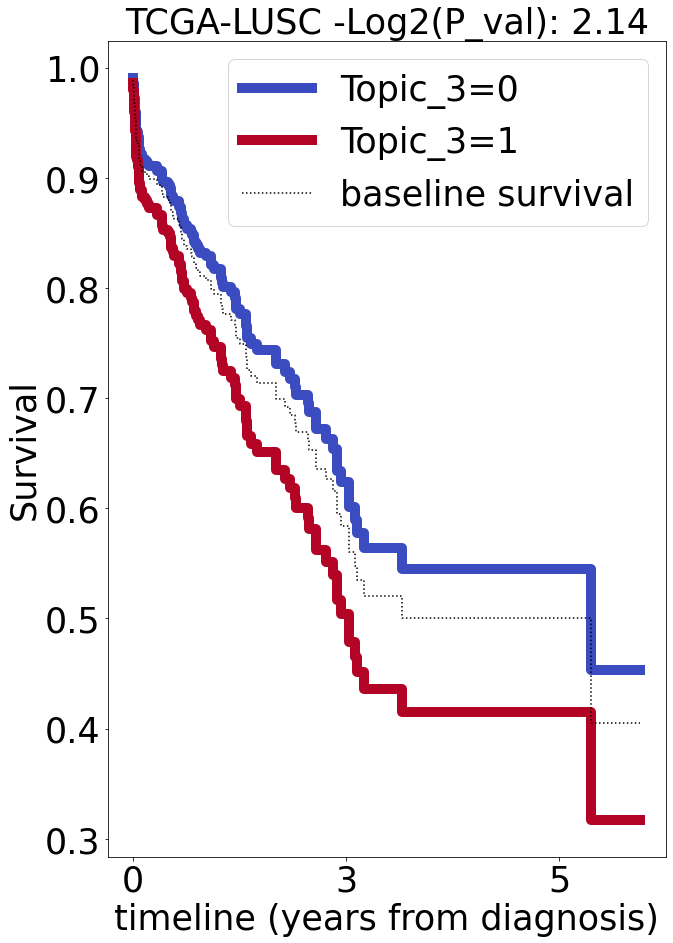

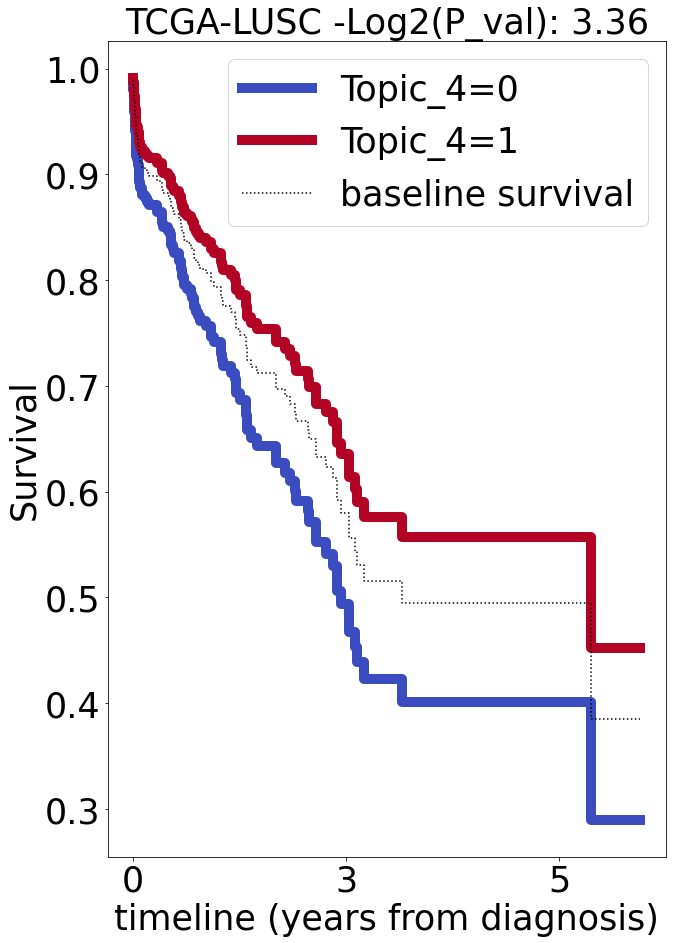

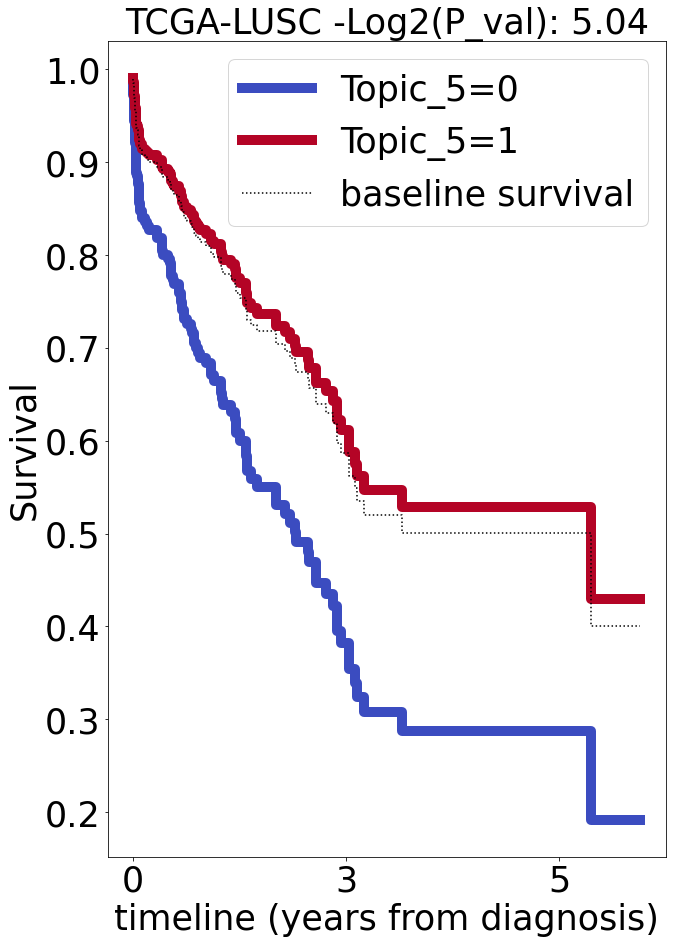

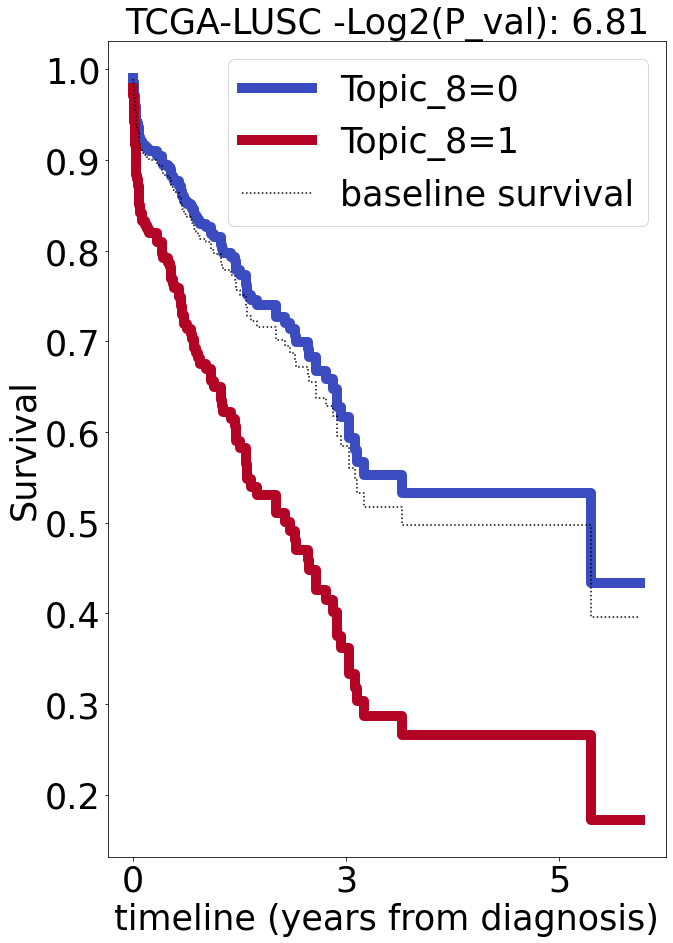

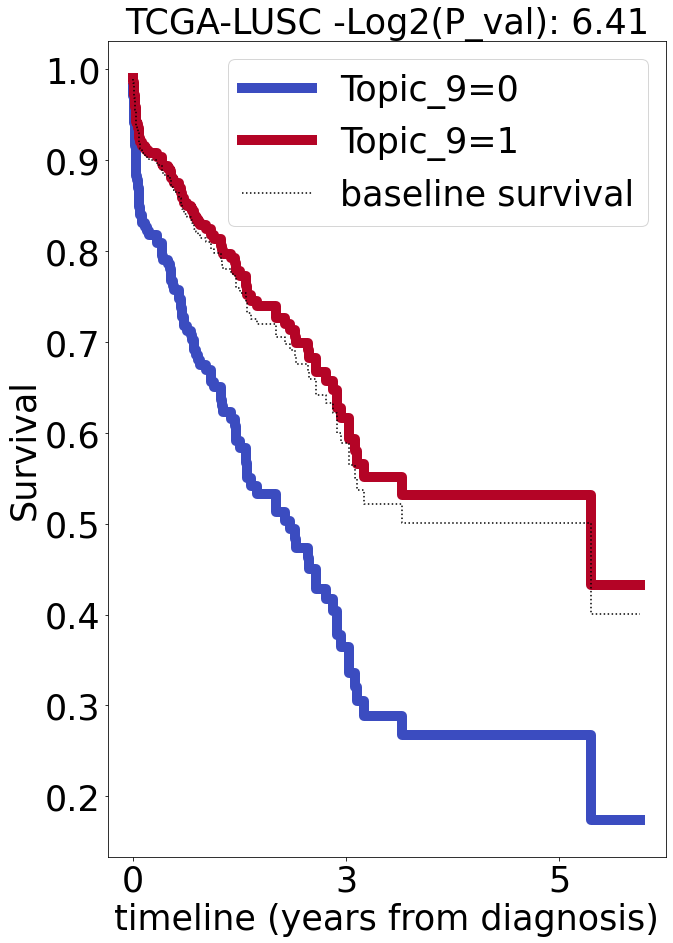

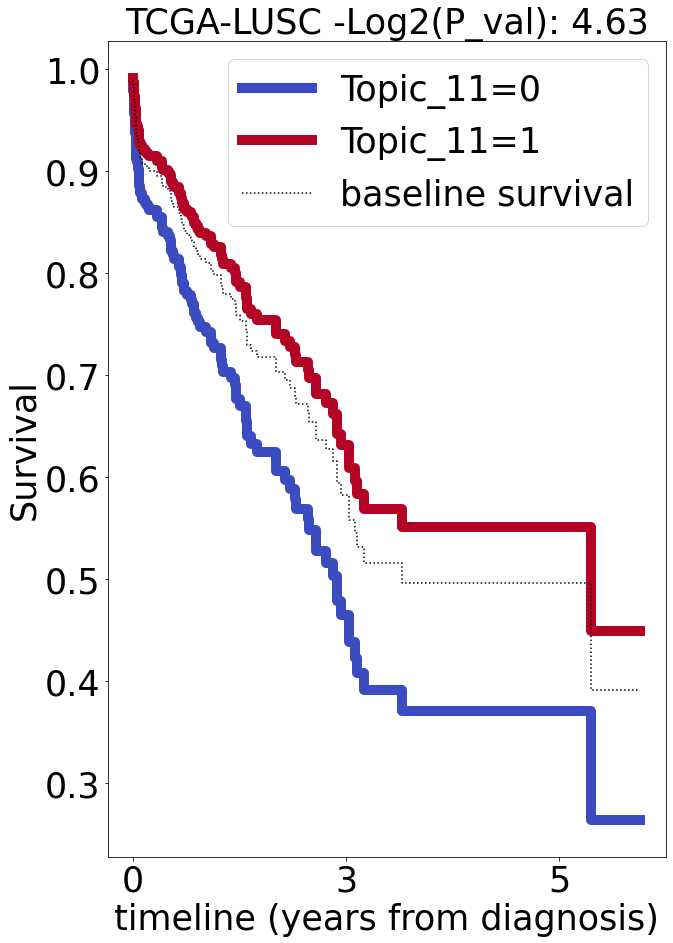

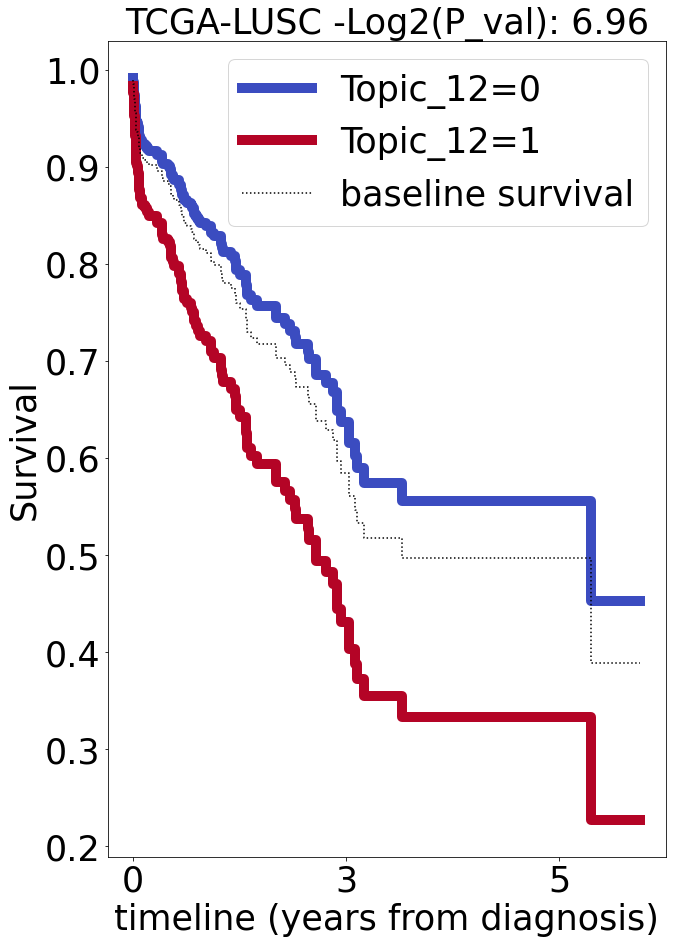

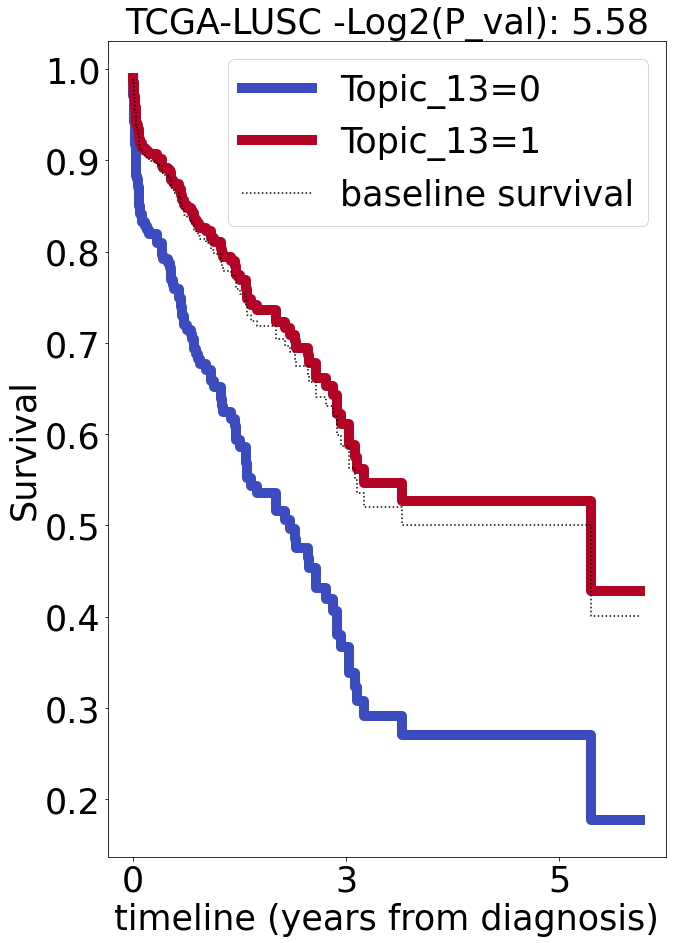

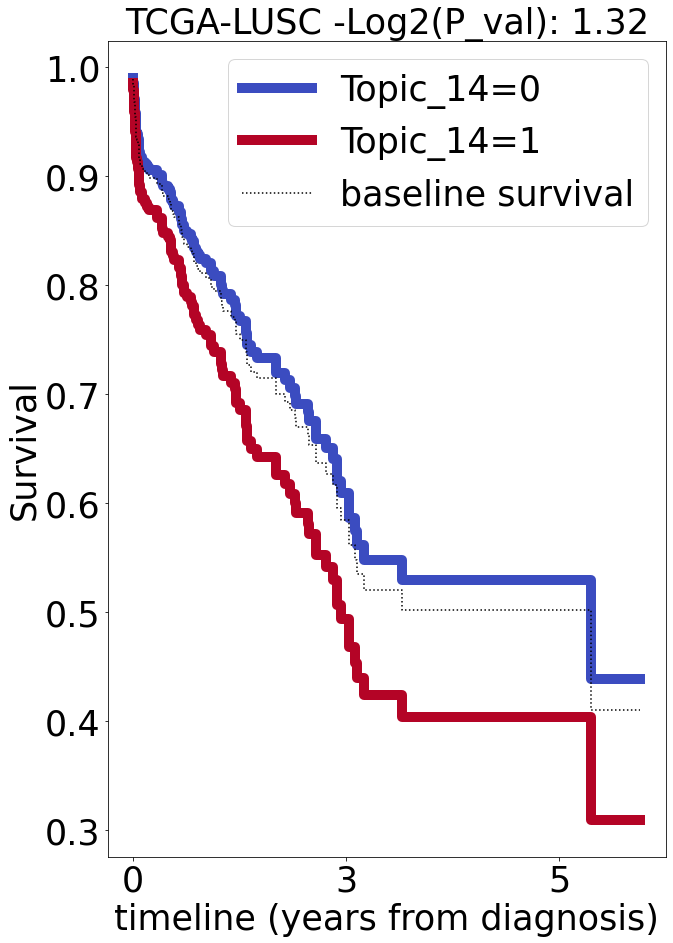

In [106]:
for dataset in ["TCGA-LUAD", "TCGA-LUSC"]:
    mask = (~df_files["days_survival"].isna()) & (df_files["cases.0.diagnoses.0.tumor_stage"]!="not reported") & (df_files["cases.0.project.project_id"]==dataset)
    subset = df_files[mask]
    subset = subset[["days_survival","vital_status","gender", "tumor_stage", "age_at_diagnosis"]]
    for topic in df_clusters.columns:
        top_set = add_group_to_subset(topic, subset, df_clusters, 0.5)
        summary, _, ax = fit_cox(top_set, topic)
        if summary is not None:
            if summary.at[summary.index[-1],"-log2(p)"] > 3:
                print(dataset,": ",topic,"\n",summary.loc[summary.index[-1],["coef", "p"]],"\n")
        if ax is not None:
            ax.set_title(dataset+" "+ax.title.get_text(), fontsize=35)

In [ ]:
summary, _, ax = fit_cox(top_set, "Topic 3")
summary

In [ ]:
for g in pd.read_csv("datasets/cancers/lung/lda/lda_level_2_topics.csv",index_col=1)["Topic 18"].values:
    print(g[:15])

In [ ]:
(pd.read_csv("datasets/cancers/lung/topsbm/topsbm_level_1_topics.csv",index_col=1)=="ENSG00000121552").any()